In [1]:
import anndata as ad
import moscot
from moscot.problems.cross_modality import TranslationProblem
import scanpy as sc
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
import scipy as sp
from scipy.spatial.distance import cdist
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu

from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2


def compute_kbet(embedding, batch_labels, k=50, alpha=0.05):
    n_cells = embedding.shape[0]
    batch_labels = np.array(batch_labels)
    unique_batches = np.unique(batch_labels)
    batch_counts = np.array([(batch_labels == b).sum() for b in unique_batches])
    batch_probs = batch_counts / n_cells

    # Nearest neighbors
    nn = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(embedding)
    distances, neighbors = nn.kneighbors(embedding)

    p_values = np.zeros(n_cells)
    rejections = np.zeros(n_cells, dtype=bool)

    for i in range(n_cells):
        neighbor_labels = batch_labels[neighbors[i]]
        observed_counts = np.array([(neighbor_labels == b).sum() for b in unique_batches])
        expected_counts = batch_probs * k

        # Chi-squared test
        with np.errstate(divide='ignore', invalid='ignore'):
            chi2_stat = np.sum((observed_counts - expected_counts) ** 2 / expected_counts)
            p_val = 1 - chi2.cdf(chi2_stat, df=len(unique_batches) - 1)
        
        p_values[i] = p_val
        rejections[i] = p_val < alpha

    rejection_rate = rejections.mean()
    return rejection_rate, p_values

def kbet_celltypes(adata, embedding_key='X_lsi', batch_key='assay', celltype_key='celltype', k=5, alpha=0.05):
    results = {}
    embedding = adata.obsm[embedding_key]
    batch_labels = adata.obs[batch_key].values
    celltypes = adata.obs[celltype_key].unique()

    for ct in celltypes:
        idx = adata.obs[celltype_key] == ct
        if idx.sum() < k:
            continue

        emb_sub = embedding[idx]
        batch_sub = batch_labels[idx]
        rejection_rate, _ = compute_kbet(emb_sub, batch_sub, k=k, alpha=alpha)
        results[ct] = rejection_rate

    return results

In [2]:
mudatacc_int = ad.read_h5ad('output/scnmt.h5ad')
scatac_int = ad.read_h5ad('output/scatac.h5ad')
scatac_int.obs['celltype'] = scatac_int.obs['cell type - scATAC']
mudat_ann = pd.read_csv('output/scnmt_annotation.csv', sep=',', index_col=0)
mudatacc_int.obs['celltype'] = mudat_ann.loc[mudatacc_int.obs.index]['celltype']
mudatacc_int.obs['assay'] = 'scNMT'
scatac_int.obs['assay'] = 'scATAC'
scatac_int.X = scatac_int.X.toarray()

In [3]:
X_all = np.vstack([mudatacc_int.X.toarray(), scatac_int.X])
svd = TruncatedSVD(n_components=100, random_state=0)
pca = PCA(n_components=50, random_state=0)
X_lsi = svd.fit_transform(X_all)
X_pca = pca.fit_transform(X_all)

mudatacc_int.obsm["X_joint_lsi"] = X_lsi[:mudatacc_int.X.shape[0]]
scatac_int.obsm["X_joint_lsi"] = X_lsi[mudatacc_int.X.shape[0]:]

mudatacc_int.obsm["X_joint_pca"] = X_pca[:mudatacc_int.X.shape[0]]
scatac_int.obsm["X_joint_pca"] = X_pca[mudatacc_int.X.shape[0]:]

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(295, 6778)].                                           


/localenv/deboutte/anaconda/miniconda/envs/moscot_book/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


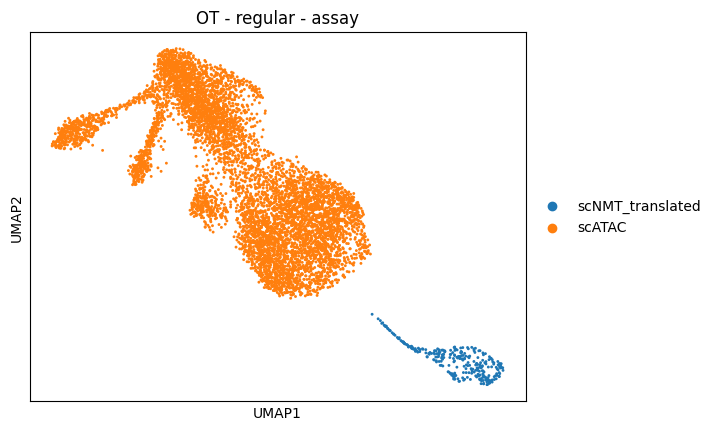

In [4]:
tp = TranslationProblem(mudatacc_int, scatac_int)
tp = tp.prepare(src_attr="X_lsi_integration", tgt_attr="X_lsi_integration")
tp = tp.solve(epsilon=1e-3)
translated = tp.translate(source="src", target="tgt", forward=True)
adata = sc.concat(
    [mudatacc_int, scatac_int],
    join="outer",
    label="assay",
    keys=["scNMT_translated", "scATAC"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, scatac_int.obsm["X_lsi_integration"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1", n_neighbors=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='assay', title='OT - regular - assay', save='integrationscatac_OT_assay.png')

INFO     Solving `1` problems                                                                                      
INFO     Solving problem OTProblem[stage='prepared', shape=(295, 6778)].                                           


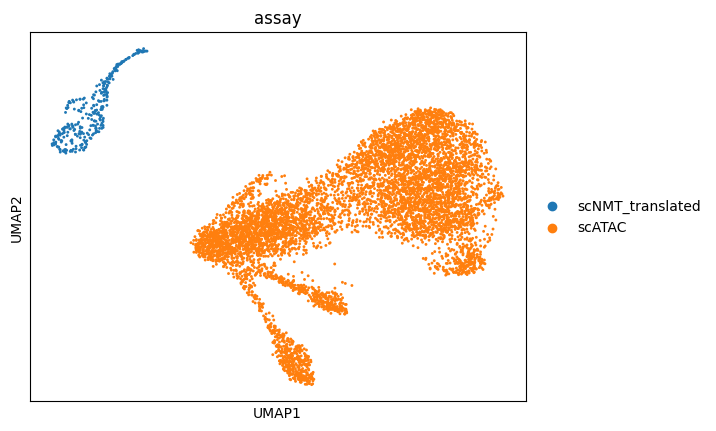

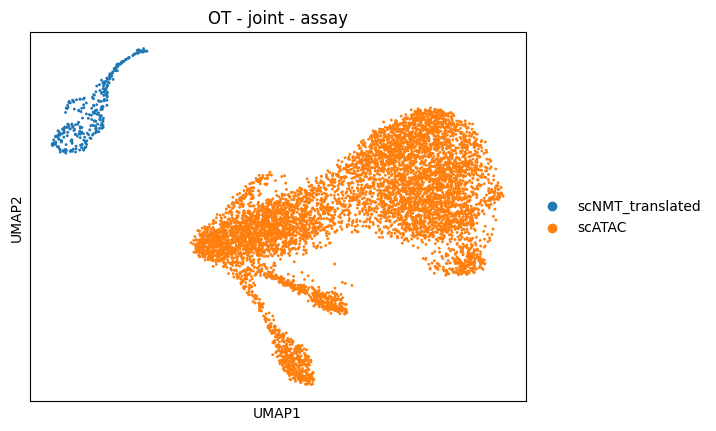

In [5]:
tp = TranslationProblem(mudatacc_int, scatac_int)
tp = tp.prepare(src_attr="X_lsi_integration", tgt_attr="X_lsi_integration", joint_attr="X_joint_pca")
tp = tp.solve(alpha=0.7, epsilon=1e-3)
translated = tp.translate(source="src", target="tgt", forward=True)
adata = sc.concat(
    [mudatacc_int, scatac_int],
    join="outer",
    label="assay",
    keys=["scNMT_translated", "scATAC"],
)
adata.obsm["X_translated_1"] = np.concatenate(
    (translated, scatac_int.obsm["X_lsi_integration"]), axis=0
)
sc.pp.neighbors(adata, use_rep="X_translated_1", n_neighbors=50)
sc.tl.umap(adata)
sc.pl.umap(adata, color='assay')
sc.pl.umap(adata, color='assay', title='OT - joint - assay', save='integrationscatac_OT_ext_assay.png')

In [6]:
import bbknn

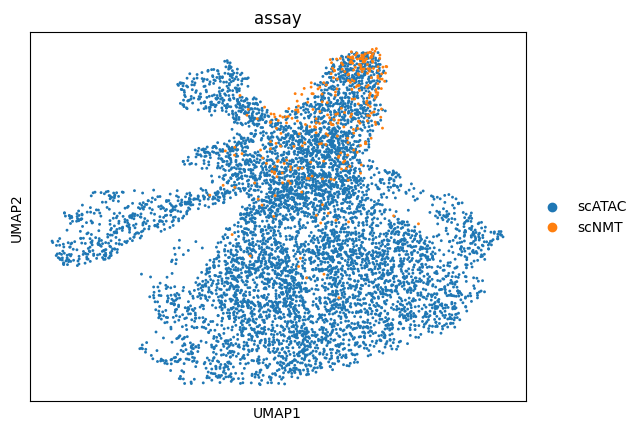

In [7]:
_bbk_scatac = scatac_int.copy()
_bbk_muda = mudatacc_int.copy()

_bbk_scatac.X = _bbk_scatac.X
_bbk_muda.X = _bbk_muda.X.toarray()

bbkadata = ad.concat([_bbk_scatac, _bbk_muda], join="outer", label="batch", fill_value=0)
bbkadata.obs['assay'] = bbkadata.obs['batch'].map({'0': 'scATAC', '1': 'scNMT'})

bbknn.bbknn(bbkadata, batch_key='assay', use_rep='X_lsi')
sc.tl.umap(bbkadata)
sc.pl.umap(bbkadata, color='assay', save='integrationscatac_BBKNN_assay.png')

#sc.pl.umap(bbkadata, color=["assay"], title='bbknn - assay', size=50, save='integration_BBKNN_assay.png')
#sc.pl.umap(bbkadata, color=["celltype"],title='bbknn - cell type', size=50, save='integration_BBKNN_celltype.png')

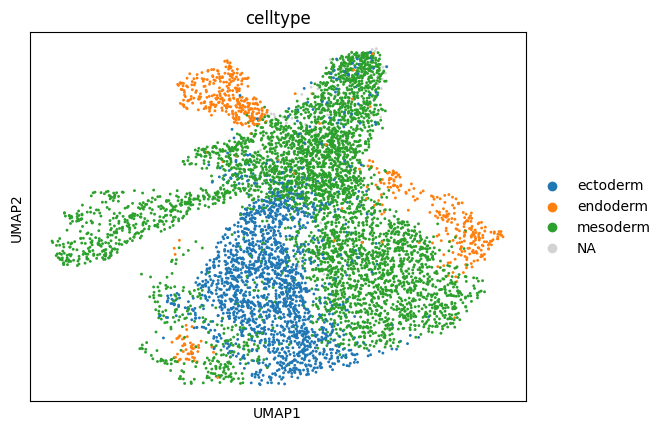

In [8]:
bbkadata.obs['celltype'] = bbkadata.obs['celltype'].str.lower()
sc.pl.umap(bbkadata, color='celltype', save='integrationscatac_BBKNN_celltype.png')

In [9]:
proj_distances=[]
def intr_dists(adata,rep_key,group_key) -> dict:
    X = adata.obsm[rep_key]
    labels = adata.obs[group_key]

    results = {}
    for group in labels.unique():
        idx = labels == group
        X_group = X[idx.values]
        dists = sp.spatial.distance.pdist(X_group)
        results[group] = dists

    unique_groups = labels.unique()

    for i, group1 in enumerate(unique_groups):
        for j in range(i + 1, len(unique_groups)):
            group2 = unique_groups[j]
            idx1 = labels == group1
            idx2 = labels == group2
            X1 = X[idx1.values]
            X2 = X[idx2.values]

            dists = cdist(X1, X2)  # shape: (n_group1, n_group2)
            results[(group1, group2)] = dists
    return results

resdic = intr_dists(bbkadata, 'X_lsi', 'celltype')
for layer in resdic:
    for dist in resdic[layer]:
        if not isinstance(dist, np.float64):
            for _d in dist:
                proj_distances.append(
                    ['BBKNN', layer, _d]
                )
        else:
            proj_distances.append(
                    ['BBKNN', layer, dist]
                )


In [10]:
resdf = pd.DataFrame(proj_distances)
resdf.head()
resdf.columns = ['method', 'layer', 'distance']
resdf['layer_collapsed'] = resdf['layer'].map({'mesoderm': 'mesoderm', 'ectoderm':'ectoderm', 'endoderm':'endoderm'})
resdf['layer_collapsed'] = resdf['layer_collapsed'].fillna('between')
dfs = []
for i in resdf['method'].unique():
    _df = resdf[resdf['method'] == i].copy()
    dfs.append(_df)
    _df2 = resdf[resdf['method'] == i].copy()
    _df2['layer_collapsed'] = 'all'
    dfs.append(_df2)
findf = pd.concat(dfs, axis=0)
findf = findf[findf['layer_collapsed'] != 'between']

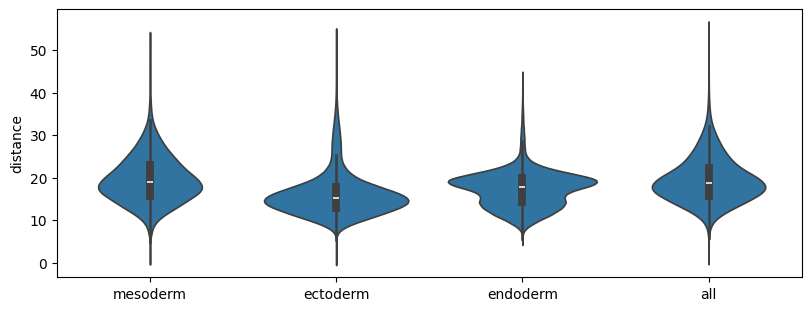

In [11]:
fig,ax = plt.subplots(figsize=(8,3), constrained_layout=True)
sns.violinplot(
    data=findf,
    x='layer_collapsed',
    y='distance',
    ax=ax
)
ax.set_xlabel('')
fig.savefig('figures/integration_performance_ATAC.png', dpi=300)

In [12]:
ress = []
for layer in ['mesoderm', 'ectoderm', 'endoderm']:    
    stat, pval = mannwhitneyu(
        resdf[resdf['layer_collapsed'] == layer]['distance'],
        resdf[resdf['layer_collapsed'] == 'between']['distance'],
        alternative='two-sided'
    )
    ress.append([stat, pval, layer])
ress


[[np.float64(60847105382760.0), np.float64(0.0), 'mesoderm'],
 [np.float64(5628488077964.0), np.float64(0.0), 'ectoderm'],
 [np.float64(893560172709.0), np.float64(0.0), 'endoderm']]